Teamnaam: Ongeneeselijk muziekaal

Teamleden:
1. needanku (Tijn)
2. jipschijvenaars (Jip)
3. joesvandeursen (Joes)
4. jimaugustinus (Jim)


Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import librosa
import numpy as np

In [ ]:
labels_df = pd.read_csv(r'C:\Users\jvand\OneDrive\Documenten\GitHub\MachineLearning\ML opdracht 3\labels_new.csv')
display(labels_df.head())


,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


<AxesSubplot: xlabel='genre'>

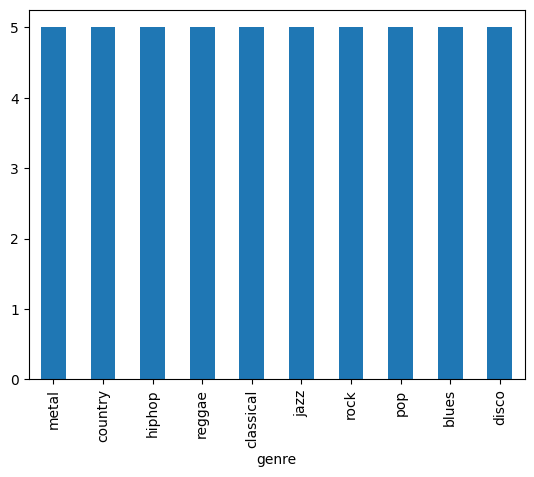

In [3]:
labels_df['genre'].value_counts().plot(kind='bar')

Genre Distribution Statistics:
------------------------------
genre
metal        5
country      5
hiphop       5
reggae       5
classical    5
jazz         5
rock         5
pop          5
blues        5
disco        5
Name: count, dtype: int64

Total number of samples: 50

Unique genres: 10


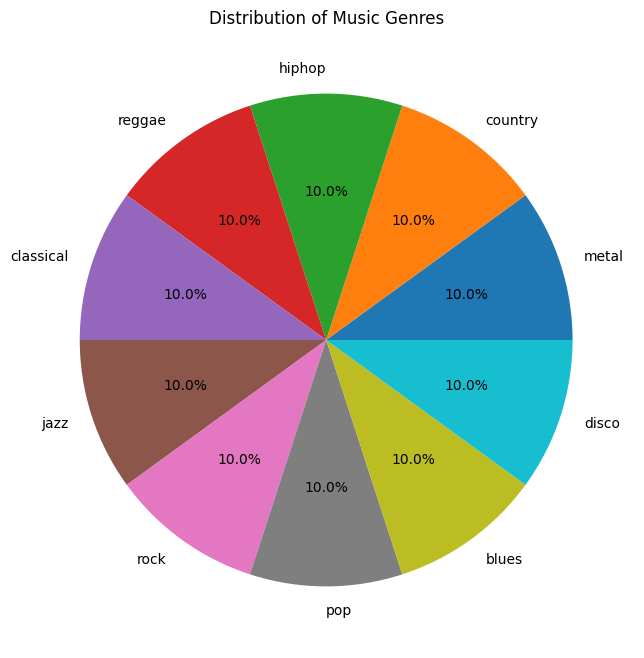

In [ ]:
print("Genre Distribution Statistics:")
print("-" * 30)
print(labels_df['genre'].value_counts())
print("\nTotal number of samples:", len(labels_df))
print("\nUnique genres:", labels_df['genre'].nunique())

plt.figure(figsize=(10, 8))
labels_df['genre'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Music Genres')
plt.ylabel('')  
plt.show()


In [5]:
audio_dir = Path(r'C:\Users\jvand\OneDrive\Documenten\GitHub\MachineLearning\ML opdracht 3\labeled')

# List all wav files and compare with the labels
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

print(f"Number of audio files found: {len(audio_files)}")
print(f"Number of labels in DataFrame: {len(labels_df)}")

# Check if all labeled files exist in the directory
missing_files = [f for f in labels_df['filename'] if f not in audio_files]
if missing_files:
    print("\nMissing audio files:")
    for f in missing_files:
        print(f)
else:
    print("\nAll labeled files found in directory!")

Number of audio files found: 50
Number of labels in DataFrame: 50

All labeled files found in directory!


## Een dataframe met audiofeatures


In [15]:
class AudioFeatureExtractor:
    def __init__(self, audio_dir):
        self.audio_dir = Path(audio_dir)
        self.features_list = []
        
    def extract_features(self, audio_files):
        for filename in audio_files:
            file_path = self.audio_dir / filename
            features = self._process_file(file_path, filename)
            self.features_list.append(features)
        return pd.DataFrame(self.features_list)
    
    def _process_file(self, file_path, filename):
        y, sr = librosa.load(file_path)
        
        features = {
            'filename': filename,
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y)),
            'rolloff': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            'flatness': np.mean(librosa.feature.spectral_flatness(y=y)),
            'tempo': librosa.beat.tempo(y=y, sr=sr)[0],
        }
        
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        features.update({f'mfcc_{i+1}': mfcc[i] for i in range(13)})
        
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        features.update({f'chroma_{i+1}': chroma[i] for i in range(12)})
        
        tempogram = librosa.feature.tempogram(y=y, sr=sr)
        features['tempogram_ratio'] = np.mean(tempogram) / np.std(tempogram)
        
        return features
    
    def merge_with_labels(self, labels_df):
        features_df = pd.DataFrame(self.features_list)
        return pd.merge(features_df, labels_df, on='filename')

extractor = AudioFeatureExtractor(audio_dir)
features_df = extractor.extract_features(audio_files)
audio_features_df = extractor.merge_with_labels(labels_df)


C:\Users\jvand\AppData\Local\Temp\ipykernel_3336\2320347012.py:26: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0],


https://librosa.org/doc/latest/feature.html

1. **Spectral Bandwidth**
- Meet de breedte van het frequentiebereik in het geluidssignaal
- Berekend als gewogen standaardafwijking van frequenties t.o.v. het spectrale zwaartepunt

2. **Spectral Centroid**
- Het "massamiddelpunt" van het spectrum, indicatie voor helderheid van het geluid
- Berekend als gewogen gemiddelde van aanwezige frequenties

3. **Zero Crossing Rate**
- Hoe vaak het signaal de nullijn kruist (van positief naar negatief of omgekeerd)
- Telt het aantal keren dat het signaal van teken wisselt

4. **Root Mean Square Energy**
- Gemiddelde energie/volume van het signaal
- Berekend als kwadratisch gemiddelde van de amplitude

5. **Spectral Rolloff**
- Frequentie waaronder het merendeel van de energie zich bevindt 
- Hier: frequentie waaronder 85% van de energie ligt

6. **MFCC**
- Representatie van kortetermijn vermogensspectrum
- Gebaseerd op cosinustransformatie van mel-geschaald logaritmisch vermogensspectrum

7. **Chroma Features**
- Verdeling van toonhoogtes over 12 halve tonen
- Geeft aan welke toonhoogtes prominent aanwezig zijn

8. **Spectral Flatness**
- Meet hoe "tonaal" vs. "ruisachtig" het geluid is
- Ratio tussen geometrisch en rekenkundig gemiddelde van spectrum

9. **Tempo**
- Geschatte snelheid van de muziek in BPM (beats per minute)
- Berekend uit ritmische patronen

10. **Tempogram Ratio**
- Verhouding tussen gemiddelde en standaardafwijking van het tempogram
- Geeft aan hoe constant het tempo is

## Opdracht 2: Unsupervised Learning

In [13]:
folder_path = r"C:\Users\jvand\OneDrive\Documenten\GitHub\MachineLearning\ML opdracht 3\unlabeled"

unlabeled = [f for f in os.listdir(folder_path) if f.endswith('.mp3') or f.endswith('.wav')]
for unlabel in unlabeled:
    print(unlabel)

m00003.wav
m00012.wav
m00013.wav
m00043.wav
m00044.wav
m00055.wav
m00061.wav
m00063.wav
m00069.wav
m00074.wav
m00107.wav
m00114.wav
m00127.wav
m00137.wav
m00139.wav
m00148.wav
m00149.wav
m00156.wav
m00183.wav
m00211.wav
m00218.wav
m00228.wav
m00247.wav
m00254.wav
m00266.wav
m00289.wav
m00292.wav
m00293.wav
m00309.wav
m00318.wav
m00321.wav
m00323.wav
m00324.wav
m00331.wav
m00348.wav
m00355.wav
m00356.wav
m00357.wav
m00359.wav
m00363.wav
m00371.wav
m00372.wav
m00391.wav
m00393.wav
m00399.wav
m00405.wav
m00414.wav
m00434.wav
m00463.wav
m00468.wav
m00487.wav
m00495.wav
m00515.wav
m00528.wav
m00537.wav
m00538.wav
m00549.wav
m00555.wav
m00560.wav
m00570.wav
m00571.wav
m00576.wav
m00581.wav
m00582.wav
m00589.wav
m00597.wav
m00610.wav
m00616.wav
m00624.wav
m00635.wav
m00685.wav
m00705.wav
m00708.wav
m00719.wav
m00730.wav
m00733.wav
m00736.wav
m00755.wav
m00756.wav
m00791.wav
m00806.wav
m00812.wav
m00817.wav
m00824.wav
m00828.wav
m00829.wav
m00833.wav
m00838.wav
m00843.wav
m00852.wav
m00873.wav